In [75]:
import json
import re
import os 
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

In [94]:
file_path = "/home/chewon1227/careerpathway/data/rank_resp/qwen-7b.jsonl"

file_list = ["/home/chewon1227/careerpathway/data/rank_resp/qwen-0.5b.jsonl",
             "/home/chewon1227/careerpathway/data/rank_resp/qwen-1.5b.jsonl",
             "/home/chewon1227/careerpathway/data/rank_resp/qwen-3b.jsonl",
             "/home/chewon1227/careerpathway/data/rank_resp/qwen-7b.jsonl",
             "/home/chewon1227/careerpathway/data/rank_resp/qwen-14b.jsonl"]

#output_dir = "/home/chewon1227/careerpathway/data/rank_result"
#os.makedirs(output_dir, exist_ok=True)

data_list = []
posts = {}
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data_list.append(json.loads(line))
        data = json.loads(line.strip())

post_map = {}
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        post_id = item.get("meta", {}).get("post_id", "")
        post = item.get("post", "")
        if post_id:
            post_map[post_id] = post

In [95]:
def parse_response(resp):
    ranking_pattern = r'(\d+\.\s*[^\n]+(?:\n\d+\.\s*[^\n]+)*)'
    ranking_match = re.search(ranking_pattern, resp)
    if not ranking_match:
        return [], ""
    ranking_text = ranking_match.group(1)
    ranked_options=[]

    for line in ranking_text.strip().split('\n'):
        if re.match(r'\d+\.', line):
            option = re.sub(r'^\d+\.\s*', '', line).strip()
            ranked_options.append(option)

    reason_pattern = r'Reason[^:]*:\s*([^\n]+)'
    reason_match = re.search(reason_pattern, resp, re.IGNORECASE)
    reason = reason_match.group(1).strip() if reason_match else ""
    return ranked_options, reason

def clean_text(text):
    if not text:
        return ""
    cleaned = text.lower().strip()
    cleaned = cleaned.replace('[', '').replace(']', '').replace('*', '')
    return cleaned

def analyze_single_file(file_path, remove_duplicates=False):
    data_list = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data_list.append(json.loads(line))
    
    # 중복 제거 (nopf 파일용)
    if remove_duplicates:
        seen_post_ids = set()
        unique_data_list = []
        for data in data_list:
            post_id = data['meta'].get('post_id', '')
            if post_id not in seen_post_ids:
                seen_post_ids.add(post_id)
                unique_data_list.append(data)
        data_list = unique_data_list
        print(f"중복 제거 후 데이터 수: {len(data_list)}개")
    
    parsed_data = []
    selected_rankings = []
    new_recommendations = []
    posts = []

    for data in data_list:
        try:
            choices = data['meta'].get('choices', [])
            selected_choice = data['meta'].get('selected_choice', '')
            response = data['response']
            ranked_options, reason = parse_response(response)
            
            selected_rank = None
            selected_choice_clean = clean_text(selected_choice)
            
            for i, option in enumerate(ranked_options):
                option_clean = clean_text(option)
                if option_clean == selected_choice_clean:
                    selected_rank = i + 1
                    break

            if selected_rank is None:
                for i, option in enumerate(ranked_options):
                    option_clean = clean_text(option)
                    if (selected_choice_clean in option_clean or 
                        option_clean in selected_choice_clean or
                        any(word in option_clean for word in selected_choice_clean.split()) or
                        any(word in selected_choice_clean for word in option_clean.split())):
                        selected_rank = i + 1
                        break
            
            if selected_rank:
                selected_rankings.append(selected_rank)
            
            new_recs = []
            choices_clean = [clean_text(c) for c in choices]
            
            for option in ranked_options:
                option_clean = clean_text(option)
                if option_clean not in choices_clean:
                    new_recs.append(option)
            
            if new_recs:
                new_recommendations.extend(new_recs)
            
            posts.append(data)
            
            parsed_data.append({
                'post_id': data['meta'].get('post_id', ''),
                'choices': choices,
                'selected_choice': selected_choice,
                'ranked_options': ranked_options,
                'selected_rank': selected_rank,
                'reason': reason,
                'new_recommendations': new_recs
            })
        except Exception as e:
            print(f"데이터 처리 중 오류: {e}")
            continue

    print(f"파싱 완료: {len(parsed_data)}개 샘플")
    return parsed_data, selected_rankings, new_recommendations


In [96]:
parsed_data, selected_rankings, new_recommendations = analyze_single_file(file_path, remove_duplicates=False)

posts = [item.get('post', {}) for item in parsed_data]
non_first_rank_data = []
for data in parsed_data:
    if data['selected_rank'] is not None and data['selected_rank'] != 1:
        non_first_rank_data.append(data)

print(f"전체 데이터: {len(parsed_data)}개")
print(f"1등이 아닌 데이터: {len(non_first_rank_data)}개")
print(f"필터링 비율: {len(non_first_rank_data)/len(parsed_data)*100:.1f}%")

파싱 완료: 10350개 샘플
전체 데이터: 10350개
1등이 아닌 데이터: 1956개
필터링 비율: 18.9%


In [99]:
df = pd.DataFrame(non_first_rank_data)
df["post"] = df["post_id"].map(post_map)
df.to_json("/home/chewon1227/careerpathway/data/rank_result/non_first_rank.json", orient='records', lines=True)

In [5]:
all_results = {}
print("=== 파일별 분석 시작 ===")

for idx, file_path in enumerate(file_list):
    try:
        result = analyze_single_file(file_path)
        
        # 반환값 확인
        if len(result) == 3:
            parsed_data, selected_rankings, new_recommendations = result
        else:
            print(f"  ✗ 오류: 예상과 다른 반환값 개수 ({len(result)})")
            continue
        
        if selected_rankings:
            # 기존 통계 계산
            avg_rank = np.mean(selected_rankings)
            best_rank = min(selected_rankings)
            worst_rank = max(selected_rankings)
            
            rank_counts = defaultdict(int)
            for rank in selected_rankings:
                rank_counts[rank] += 1
            
            all_results[idx] = {
                'rankings': selected_rankings,
                'avg_rank': avg_rank,
                'best_rank': best_rank,
                'worst_rank': worst_rank,
                'num_samples': len(selected_rankings),
                'rank_counts': rank_counts,
                'new_recommendations': new_recommendations
            }
            
            print(f"  ✓ 성공: {len(selected_rankings)}개 샘플")
            print(f"  평균 순위: {avg_rank:.2f}")
            print(f"  최고 순위: {best_rank}")
            print(f"  최저 순위: {worst_rank}")
        else:
            print(f"  ✗ 실패: 유효한 데이터 없음")
            
    except Exception as e:
        print(f"  ✗ 오류: {e}")
        import traceback
        traceback.print_exc()


=== 파일별 분석 시작 ===
파싱 완료: 10349개 샘플
  ✓ 성공: 5677개 샘플
  평균 순위: 1.51
  최고 순위: 1
  최저 순위: 31
파싱 완료: 10349개 샘플
  ✓ 성공: 8204개 샘플
  평균 순위: 1.41
  최고 순위: 1
  최저 순위: 10
파싱 완료: 10349개 샘플
  ✓ 성공: 10231개 샘플
  평균 순위: 1.26
  최고 순위: 1
  최저 순위: 10
파싱 완료: 10350개 샘플
  ✓ 성공: 10218개 샘플
  평균 순위: 1.28
  최고 순위: 1
  최저 순위: 8
파싱 완료: 10350개 샘플
  ✓ 성공: 10134개 샘플
  평균 순위: 1.34
  최고 순위: 1
  최저 순위: 12


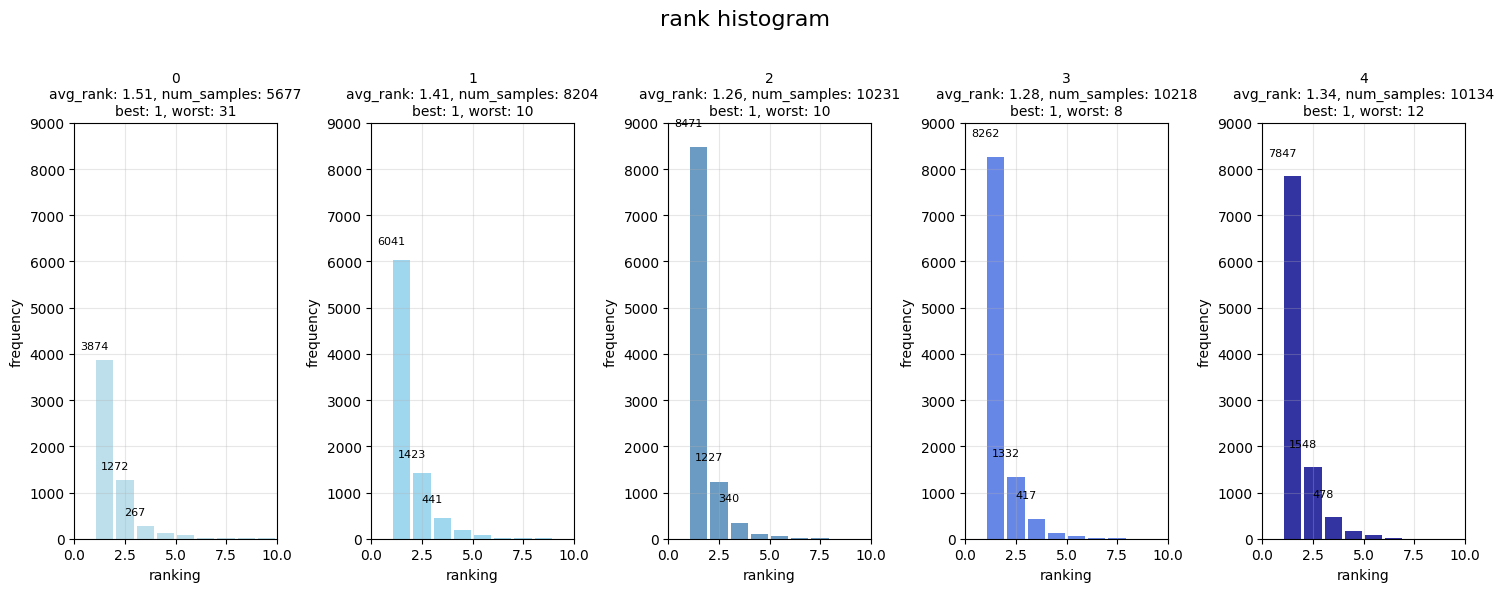

In [6]:
import matplotlib.pyplot as plt

if all_results:
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))
    axes = axes.flatten()

    colors = ['lightblue', 'skyblue', 'steelblue', 'royalblue', 'darkblue']

    for idx, (label, results) in enumerate(all_results.items()):
        if idx >= len(axes):
            break
            
        rankings = results['rankings']
        rank_counts = results['rank_counts']
        
        # 히스토그램 그리기
        axes[idx].hist(rankings, bins=range(1, max(rankings)+2), 
                       color=colors[idx % len(colors)], alpha=0.8, rwidth=0.85)
        
        axes[idx].set_xlim(0, 10)
        axes[idx].set_ylim(0, 9000)

        # 통계 정보 표시
        title = f"{label}\navg_rank: {results['avg_rank']:.2f}, num_samples: {results['num_samples']}\n"
        title += f"best: {results['best_rank']}, worst: {results['worst_rank']}"
        
        axes[idx].set_title(title, fontsize=10)
        axes[idx].set_xlabel('ranking')
        axes[idx].set_ylabel('frequency')
        axes[idx].grid(True, alpha=0.3)
        
        # 상위 3개 순위만 텍스트로 표시
        for rank in sorted(rank_counts.keys())[:3]:
            count = rank_counts[rank]
            axes[idx].text(rank, count + max(rank_counts.values())*0.05, 
                          f'{count}', ha='center', va='bottom', fontsize=8)

    plt.suptitle('rank histogram', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [50]:
if new_recommendations:
    print("\n=== new recs ===")
    rec_counts = defaultdict(int)
    for rec in new_recommendations:
        rec_counts[rec] += 1
    
    for rec, count in sorted(rec_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {rec}: {count} recs")
else:
    print("\n새로운 추천 옵션이 없습니다.")


=== new recs ===
  (No third option provided): 103 recs
  (No other options provided): 65 recs
  [No third option provided]: 38 recs
  (There is no third option): 37 recs
  (There are only two options provided): 35 recs
  [Option name]: 34 recs
  (There is no third option in this scenario): 34 recs
  (No third option as only two were provided): 22 recs
  (No other option provided): 20 recs
  (There is no third option in the given choices): 19 recs
  : 19 recs
  [There is no third option in the given choices]: 19 recs
  [There is no third option]: 18 recs
  [No other options provided]: 17 recs
  (There are only two options, so no third option): 14 recs
  None: 13 recs
  (There are only two options provided, but if there were a third, it would be ranked here): 12 recs
  (No third option as only two options are provided): 11 recs
  (No third option as only two options were provided): 11 recs
  (No third option provided, but if there were, it would be ranked here): 11 recs
  (There is no 

In [51]:
df_data = []
for item in parsed_data:
    df_data.append({
        'post_id': item['post_id'],
        'choices': ', '.join(item['choices']),
        'selected_choice': item['selected_choice'],
        'ranked_options': ', '.join(item['ranked_options']),
        'selected_rank': item['selected_rank'],
        'reason': item['reason'],
        'new_recommendations': ', '.join(item['new_recommendations'])
    })

df = pd.DataFrame(df_data)

print(df['selected_rank'].isna().sum())

216


In [52]:
reason_data = []
for item in parsed_data:
    if item['reason'] and item['reason'].strip():
        reason_data.append({
            'post_id': item['post_id'],
            'selected_choice': item['selected_choice'],
            'ranked_options': item['ranked_options'],
            'reason': item['reason']
        })

df = pd.DataFrame(reason_data)
df.to_json(f"/home/chewon1227/careerpathway/data/rank_result/reason_data.json", orient='records', lines=True)

선호도 문장 안 붙은 파일과 비교하기 